In [ ]:
 !pip install kaggle

In [ ]:
 !mkdir ~/.kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

100% 4.30G/4.31G [00:23<00:00, 143MB/s]
100% 4.31G/4.31G [00:23<00:00, 193MB/s]


In [ ]:
!ls -alh /content/pascalvoc-yolo.zip

-rw-r--r-- 1 root root 4.4G Oct 13  2020 /content/pascalvoc-yolo.zip


In [ ]:
!unzip -qq /content/pascalvoc-yolo.zip

In [ ]:
!ls -alh

total 4.4G
drwxr-xr-x 1 root root 4.0K Nov 24 04:12 .
drwxr-xr-x 1 root root 4.0K Nov 24 04:06 ..
-rw-r--r-- 1 root root 2.3K Oct 13  2020 100examples.csv
-rw-r--r-- 1 root root  186 Oct 13  2020 8examples.csv
drwxr-xr-x 4 root root 4.0K Nov 21 14:21 .config
-rw-r--r-- 1 root root  763 Oct 13  2020 generate_csv.py
-rw-r--r-- 1 root root 2.5K Oct 13  2020 get_data
drwxr-xr-x 2 root root 1.4M Nov 24 04:12 images
-rw-r--r-- 1 root root   76 Nov 24 04:10 kaggle.json
drwxr-xr-x 2 root root 660K Nov 24 04:12 labels
-rw-r--r-- 1 root root 4.4G Oct 13  2020 pascalvoc-yolo.zip
drwxr-xr-x 1 root root 4.0K Nov 21 14:24 sample_data
-rw-r--r-- 1 root root 112K Oct 13  2020 test.csv
-rw-r--r-- 1 root root 485K Oct 13  2020 train.csv


# Setup and Neccessary Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from matplotlib import patches
from PIL import Image

from collections import Counter

import torch
from torch import nn
from torch import optim
from torch.nn import Module
from torch.nn import functional as f
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.conv import Conv2d
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import utils as Vision_utils
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as TF

from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Dataset Class and DataLoader

In [ ]:
# Xác định lớp tập dữ liệu tùy chỉnh từ dataset của PyTorch
class VOCDataset(Dataset):
  # Khởi tạo đối tượng tập dữ liệu
    def __init__(self, csv_file, img_dir, label_dir, S = 7, B = 2, C = 20, transforms = None) :

        # Đọc dữ liệu chú thích từ tệp CSV vào một DataFrame của Pandas
        self.annotations = pd.read_csv(csv_file)
        # Thiết lập thư mục chứa hình ảnh
        self.img_dir = img_dir
        # Thiết lập thư mục chứa các tệp nhãn với thông tin về box giới hạn
        self.label_dir = label_dir
        # Thiết lập hàm biến đổi hình ảnh
        self.transform = transform
        # Thiết lập các tham số cho thuật toán YOLO (kích thước lưới_size, số box giới hạn_box, số lớp đối tượng)
        self.S = S
        self.B = B
        self.C = C

    # Lấy tổng số lượng mục trong tập dữ liệu
    def __len__(self) :
        return len(self.annotations)

    # Lấy một mục cụ thể từ tập dữ liệu
    def __getitem__(self, index) :
        # Tạo đường dẫn đến tệp nhãn cho mục hiện tại
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        # Khởi tạo một danh sách trống để lưu trữ thông tin về box giới hạn
        boxes = list()
        # Đọc từng dòng trong tệp nhãn để trích xuất nhãn lớp và tọa độ box giới hạn cho mỗi đối tượng trong hình ảnh
        with open(label_path) as f:
            for label in f.readlines():
                # Chuyển đổi mỗi giá trị thành float hoặc int và thêm vào danh sách
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x) for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, width, height])
        # Tạo đường dẫn đến tệp hình ảnh cho mục hiện tại
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        # Mở hình ảnh sử dụng thư viện Python Imaging Library (PIL)
        image = Image.open(img_path)
        # Chuyển đổi danh sách các box giới hạn thành tensor PyTorch
        boxes = torch.tensor(boxes)

        # Áp dụng các biến đổi hình ảnh nếu chúng được chỉ định
        if self.transform is not None :
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Chuyển đổi tọa độ box giới hạn thành một tensor đại diện cho thông tin đúng (ground truth)
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i, j đại diện cho dòng ô và cột ô trong lưới YOLO
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            # Tính toán chiều rộng và chiều cao của box giới hạn so với ô lưới
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # Nếu chưa có đối tượng nào được tìm thấy cho ô cụ thể i, j
            if label_matrix[i, j, 20] == 0:
                # Tồn tại một đối tượng
                label_matrix[i, j, 20] = 1

                # Tọa độ Box
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                # Đặt giá trị tọa độ box giới hạn trong ma trận nhãn
                label_matrix[i, j, 21:25] = box_coordinates

                # Đặt mã hóa one-hot cho class_label
                label_matrix[i, j, class_label] = 1
        # Trả về hình ảnh đã xử lý và label_matrix
        return image, label_matrix

# Other Utility Functions

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Tính toán độ chồng lấn giữa các box giới hạn
    Parameters:
        boxes_preds (tensor): Dự đoán về các box giới hạn (BATCH_SIZE, 4)
        boxes_labels (tensor): Nhãn chính xác của các box giới hạn (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, nếu box giới hạn được biểu diễn dưới dạng (x,y,w,h) hoặc (x1,y1,x2,y2)
    Returns:
        tensor: Độ chồng lấn giữa các ví dụ
    """

    # Kiểm tra nếu định dạng box là "midpoint"
    if box_format == "midpoint":
        # Tính toán tọa độ của điểm trên bên trái (x1, y1) và điểm dưới bên phải (x2, y2) cho các box dự đoán
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        # Tính toán tọa độ của điểm trên bên trái (x1, y1) và điểm dưới bên phải (x2, y2) cho nhãn thực
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    # Kiểm tra nếu định dạng box là "corners"
    if box_format == "corners":
        # Trích xuất tọa độ cho các box dự đoán
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)

        # Trích xuất tọa độ cho nhãn thực
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Tính toán tọa độ của hình chữ nhật giao nhau
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) dùng để xử lý trường hợp chúng không giao nhau
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Tính toán diện tích của hình chữ nhật giao nhau
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Trả về tỷ lệ độ chồng lấn giữa các box giới hạn, thêm một epsilon nhỏ để tránh chia cho 0
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Thực hiện Non-Maximum Suppression trên danh sách các box giới hạn
    Parameters:
        bboxes (list): Danh sách các box giới hạn, mỗi box được biểu diễn như [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): Ngưỡng IoU để xác định box giới hạn dự đoán là đúng
        threshold (float): Ngưỡng để loại bỏ các box giới hạn dự đoán (không phụ thuộc vào IoU)
        box_format (str): "midpoint" hoặc "corners" để chỉ định định dạng của box giới hạn
    Returns:
        list: Danh sách các box giới hạn sau khi thực hiện NMS với một ngưỡng IoU cụ thể
    """

    # Kiểm tra kiểu dữ liệu của tham số đầu vào
    assert type(bboxes) == list

    # Lọc các box giới hạn dự đoán dựa trên ngưỡng xác suất
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sắp xếp các box giới hạn theo xác suất giảm dần
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Danh sách để lưu trữ các box giới hạn sau khi thực hiện NMS
    bboxes_after_nms = []

    # Thực hiện vòng lặp cho đến khi danh sách box giới hạn rỗng
    while bboxes:
        # Lấy box giới hạn có xác suất cao nhất
        chosen_box = bboxes.pop(0)

        # Loại bỏ các box giới hạn có IoU lớn hơn ngưỡng được chỉ định với box giới hạn đã chọn
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        # Thêm box giới hạn đã chọn vào danh sách sau khi thực hiện NMS
        bboxes_after_nms.append(chosen_box)

    # Trả về danh sách các box giới hạn sau khi thực hiện NMS
    return bboxes_after_nms

In [ ]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Tính giá trị trung bình độ chính xác (mAP)
    Parameters:
        pred_boxes (list): danh sách chứa các box giới hạn dự đoán với mỗi box được chỉ định như [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Tương tự như pred_boxes nhưng chứa thông tin về các box đúng
        iou_threshold (float): ngưỡng IoU, nơi các box dự đoán được coi là đúng
        box_format (str): "midpoint" hoặc "corners" được sử dụng để chỉ định định dạng của các box
        num_classes (int): số lượng lớp
    Returns:
        float: Giá trị mAP qua tất cả các lớp với một ngưỡng IoU cụ thể
    """

    # Danh sách lưu trữ mAP cho từng lớp
    average_precisions = []

    # Sử dụng để ổn định số học sau này
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Xem qua tất cả các dự đoán và mục tiêu,
        # và chỉ thêm những cái thuộc về
        # lớp c hiện tại
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Tìm số lượng box cho mỗi ví dụ huấn luyện
        # Counter ở đây tìm số lượng box đích mà chúng ta có
        # cho mỗi ví dụ huấn luyện, vì vậy giả sử ảnh 0 có 3,
        # ảnh 1 có 5 thì chúng ta sẽ có một từ điển với:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # Chúng ta sau đó duyệt qua mỗi key, val trong từ điển này
        # và chuyển đổi sang dạng sau (đối với cùng một ví dụ):
        # amount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sắp xếp theo xác suất box, index 2 là xác suất
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # Nếu không có box nào tồn tại cho lớp này thì có thể bỏ qua an toàn
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Chỉ lấy ra các box đích có cùng
            # chỉ số huấn luyện như dự đoán
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                #Chỉ detect ground truth một lần
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive và thêm box giới hạn này vào để xem
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # nếu IOU thấp hơn thì kết quả phát hiện là false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz để tích hợp số
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

# Hàm nhận một hình ảnh và danh sách các hộp giới hạn dự đoán, sau đó vẽ các hộp đó lên hình ảnh.
def plot_image(image, boxes):
    """Vẽ các hộp giới hạn dự đoán lên hình ảnh"""
    im = np.array(image)
    height, width, _ = im.shape

    # Tạo hình và trục
    fig, ax = plt.subplots(1)
    #Hiển thị hình ảnh
    ax.imshow(im)

    # box[0] là x trung điểm, box[2] là chiều rộng
    # box[1] là trung điểm y, box[3] là chiều cao

    # Tạo một hình chữ nhật
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Có nhiều giá trị hơn x, y, w, h trong một hộp"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Thêm hình chữ nhật vào Trục
        ax.add_patch(rect)

    plt.show()

# Hàm nhận các dự đoán từ mô hình và box thực tế từ tập dữ liệu.
# Sau đó, nó áp dụng hàm non_max_suppression để có được các box giới hạn cuối cùng
# và trả về danh sách các box giới hạn dự đoán và box thực tế.
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # Đảm bảo mô hình ở chế độ đánh giá trước khi lấy box giới hạn
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # Uncomment để hiển thị hình ảnh và hộp giới hạn dự đoán
            # if batch_idx == 0 and idx == 0:
            #     plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #     print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # Nhiều box sẽ được chuyển thành 0 nếu dự đoán
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def convert_cellboxes(predictions, S=7):
    """
    Chuyển đổi các hộp giới hạn được đầu ra từ YOLO với
    kích thước chia ảnh S thành tỷ lệ của toàn bộ ảnh
    thay vì tỷ lệ của ô. Đã thử cài đặt này
    theo cách vector hóa, nhưng nó dẫn đến mã khó đọc...
    Sử dụng như một hộp đen? Hoặc thực hiện một cài đặt
    thông minh hơn, sử dụng 2 for loops để lặp qua range(S)
    và chuyển đổi chúng một cách từng cái một, dẫn đến
    một cài đặt chậm hơn nhưng dễ đọc hơn.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

#Hàm nhận đầu ra của mô hình YOLO (đã được chuyển đổi bằng hàm convert_cellboxes)
#và chuyển đổi nó thành danh sách các hộp giới hạn.

#Mỗi box giới hạn được biểu diễn bằng một danh sách chứa thông tin như index
#của training example, class prediction, probability score, và tọa độ của box giới hạn.
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

#Hàm lưu trạng thái của mô hình và bộ tối ưu vào một tệp checkpoint. Tên tệp mặc định là "my_checkpoint.pth.tar".
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


#Hàm tải trạng thái của mô hình và bộ tối ưu từ một checkpoint đã được lưu trước đó.
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# Training Function

In [ ]:
"""
Thông tin về cấu hình kiến trúc:
Tuple được cấu trúc bởi (kernel_size, bộ lọc, bước tiến, phần đệm)
"M" chỉ đơn giản là maxpooling với sải chân 2x2 và kernel 2x2
Danh sách được cấu trúc theo bộ dữ liệu và cuối cùng là int với số lần lặp lại
"""
# Mô tả các lớp convolution và max pooling, số lần lặp lại các khối convolution.
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

# Một khối convolution được định nghĩa với các lớp Conv2d, BatchNorm2d, và LeakyReLU.
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

# Mô hình YOLOv1 được định nghĩa với các lớp convolution và các lớp fully connected layer (fcs).
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

# Hàm tạo ra các lớp convolution dựa trên cấu trúc kiến trúc đã được định nghĩa trước đó.
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

# Hàm tạo ra các lớp fully connected layer dựa trên các thông số đầu vào như kích thước ô chia, số lượng hộp, và số lớp.
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

# Loss Functions and Modules

In [ ]:
# Một lớp từ nn.Module để tính toán hàm mất mát cho mô hình YOLOv1.
class YoloLoss(nn.Module):
    """
    Tính loss cho mô hình yolo (v1)
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S là kích thước chia nhỏ của ảnh (7),
        B là số hộp (2),
        C là số lớp (tập dữ liệu VOC là 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # Đây là từ Yolo, biểu thị mức độ nên làm
        # trả lỗ cho không có đối tượng (noobj) và hộp tọa độ (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Dự đoán được định hình (BATCH_SIZE, S*S(C+B*5) khi được nhập vào
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Tính IoU cho hai hộp giới hạn được dự đoán với hộp mục tiêu
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Lấy hộp có IoU cao nhất trong 2 dự đoán
        # Lưu ý bestbox sẽ có chỉ số 0, 1 bbox nào tốt nhất
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Đặt các box không có đối tượng trong đó thành 0. Lấy ra một trong hai
        # dự đoán, là dự đoán có Iou cao nhất được tính toán trước đó.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Lấy sqrt của chiều rộng, chiều cao của box để đảm bảo
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box là điểm tin cậy của bbox có IoU cao nhất
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(dự đoán[..., 20:21], dự đoán[..., 25:26])
        #no_object_loss = self.mse(
        # torch.flatten((1 - tồn tại_box) * max_no_obj, start_dim=1),
        # torch.flatten((1 - tồn tại_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # 2 hàng đầu
            + object_loss  # hàng thứ 3 in paper
            + self.lambda_noobj * no_object_loss  # hàng thứ 4
            + class_loss  # hàng thứ 5
        )

        return loss

# Training Loop

In [ ]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
# Tốc độ học tập cho trình tối ưu hóa.
LEARNING_RATE = 2e-5
# Chỉ định sử dụng "cuda" (GPU) hay "cpu" để đào tạo.
DEVICE = "cuda"
# 64 trong bài báo gốc, nhưng sử dụng kích thước lô nhỏ hơn do hạn chế về GPU
BATCH_SIZE = 16
# Giảm trọng lượng cho trình tối ưu hóa để ngăn chặn việc overfitting.
WEIGHT_DECAY = 0
# Số lượng epochs đào tạo.
EPOCHS = 100
# Số lượng quy trình WORKER để tải dữ liệu.
NUM_WORKERS = 2
# Nếu Đúng, DataLoader sẽ ghim bộ nhớ để truyền dữ liệu tới GPU nhanh hơn.
PIN_MEMORY = True
# Nếu Sai, quá trình đào tạo sẽ tải mô hình được huấn luyện trước.
LOAD_MODEL = False
# Chỉ định tên tệp cho mô hình được đào tạo trước.
LOAD_MODEL_FILE = "overfit.pth.tar"
# Thư mục chứa hình ảnh.
IMG_DIR = '/content/images'
# Thư mục chứa các nhãn tương ứng.
LABEL_DIR = '/content/labels'

In [ ]:
# Kết hợp một danh sách các biến đổi ảnh và hộp giới hạn.
class Compose(object):
  # Khởi tạo đối tượng với một danh sách các biến đổi.
    def __init__(self, transforms):
        self.transforms = transforms

  # Áp dụng từng biến đổi cho ảnh và giữ nguyên các hộp giới hạn.
    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

# Tạo một đối tượng biến đổi transform bằng cách sử dụng lớp Compose.
# Các biến đổi bao gồm thay đổi kích thước ảnh thành (448, 448) và chuyển đổi ảnh thành tensor PyTorch.
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

# Định nghĩa hàm train_fn để huấn luyện mô hình.
def train_fn(train_loader, model, optimizer, loss_fn):
  # Sử dụng thanh tiến trình tqdm để hiển thị quá trình huấn luyện.
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

# Lặp qua từng batch, chuyển dữ liệu đầu vào và đầu ra sang DEVICE, tính loss, thực hiện lan truyền ngược và cập nhật trọng số của mô hình.
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        # Hiển thị giá trị trung bình của loss sau mỗi epoch.
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Cập nhật thanh tiến trình
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
  # Khởi tạo mô hình YOLOv1, tối ưu hóa Adam, và hàm mất mát YOLO.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    # Nếu có yêu cầu, tải một mô hình đã được lưu trước đó.
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    # Tạo bộ dữ liệu huấn luyện và kiểm thử (VOCDataset) với các tham số được chỉ định.
    train_dataset = VOCDataset(
        "/content/100examples.csv",
        transforms = transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/content/test.csv", transforms=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    # Tạo DataLoader cho bộ dữ liệu huấn luyện và kiểm thử với các cài đặt được chỉ định.
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    # Lặp qua mỗi epoch và tính toán các hộp giới hạn dự đoán và thực tế sử dụng hàm get_bboxes.
    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )
        # Tính trung bình độ chính xác trung bình (mAP) sử dụng hàm mean_average_precision.
        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        # Nếu mAP vượt qua ngưỡng 0.9, lưu mô hình và trạng thái tối ưu hóa.
        if mean_avg_prec > 0.9:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
            import time
            time.sleep(10)

        # Gọi hàm huấn luyện train_fn để thực hiện quá trình huấn luyện.
        train_fn(train_loader, model, optimizer, loss_fn)

In [ ]:
# Kiểm tra xem mã nguồn được thực thi trực tiếp hay được nhập vào một module khác.
# Nếu đoạn mã được thực thi trực tiếp (chứ không phải được nhập vào một module khác), hàm main() sẽ được gọi
# để bắt đầu quá trình huấn luyện và thực hiện các tác vụ chính của chương trình.
if __name__ == "__main__":
    main()

Train mAP: 0.0


100%|██████████| 6/6 [00:03<00:00,  1.94it/s, loss=986]

Mean loss was 962.8020222981771


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=424]

Mean loss was 565.4219665527344


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=521]

Mean loss was 449.2681477864583


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.67it/s, loss=429]

Mean loss was 385.0348205566406


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=387]

Mean loss was 325.61717478434247


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=175]

Mean loss was 283.07948303222656


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=192]

Mean loss was 240.78522745768228


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=217]

Mean loss was 210.62125651041666


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=236]

Mean loss was 186.9204978942871


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=135]

Mean loss was 174.84604136149088


Train mAP: 0.001438572769984603


100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=126]

Mean loss was 167.21857070922852


Train mAP: 0.15596625208854675


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=184]

Mean loss was 154.3493855794271


Train mAP: 0.28757017850875854


100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=171]

Mean loss was 141.41536712646484


Train mAP: 0.26367881894111633


100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=116]

Mean loss was 132.9553362528483


Train mAP: 0.33820289373397827


100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=128]

Mean loss was 117.76758066813152


Train mAP: 0.38739484548568726


100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=117]

Mean loss was 101.51163864135742


Train mAP: 0.4739268720149994


100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=90]

Mean loss was 96.74064636230469


Train mAP: 0.5697468519210815


100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=114]

Mean loss was 95.10324350992839


Train mAP: 0.5891466736793518


100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=101]

Mean loss was 88.23297754923503


Train mAP: 0.6425259709358215


100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=52.3]

Mean loss was 77.2778689066569


Train mAP: 0.6967263221740723


100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=77.6]

Mean loss was 81.57542419433594


Train mAP: 0.7237759232521057


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=99.2]

Mean loss was 77.31141789754231


Train mAP: 0.6916340589523315


100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=77.3]

Mean loss was 78.13929494222005


Train mAP: 0.7002214789390564


100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=66.7]

Mean loss was 69.4097277323405


Train mAP: 0.7584788203239441


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=62.6]

Mean loss was 66.86710357666016


Train mAP: 0.757438063621521


100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=74.4]

Mean loss was 62.9786319732666


Train mAP: 0.7638417482376099


100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=91]

Mean loss was 65.21682929992676


Train mAP: 0.7837478518486023


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=81.6]

Mean loss was 64.41787783304851


Train mAP: 0.8075214624404907


100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=61.8]

Mean loss was 57.97393035888672


Train mAP: 0.8322202563285828


100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=79.4]

Mean loss was 56.209498723347984


Train mAP: 0.8027932047843933


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=48.3]

Mean loss was 56.71836598714193


Train mAP: 0.8066485524177551


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=50.5]

Mean loss was 53.40440432230631


Train mAP: 0.8149251937866211


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=69.8]

Mean loss was 54.26807117462158


Train mAP: 0.8095145225524902


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=66.3]

Mean loss was 55.12769317626953


Train mAP: 0.8394129872322083


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=48.7]

Mean loss was 49.33483632405599


Train mAP: 0.8243381381034851


100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=63]

Mean loss was 48.09799416859945


Train mAP: 0.8266414403915405


100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=29]

Mean loss was 47.89559364318848


Train mAP: 0.8335824012756348


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=33.5]

Mean loss was 43.35393397013346


Train mAP: 0.8308261036872864


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=60.7]

Mean loss was 41.085693995157875


Train mAP: 0.8786718249320984


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=37.1]

Mean loss was 43.4809684753418


Train mAP: 0.8336668014526367


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=69.2]

Mean loss was 51.9468199412028


Train mAP: 0.8692396879196167


100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=54.7]

Mean loss was 46.81653340657552


Train mAP: 0.8584367036819458


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=37.9]

Mean loss was 44.644775390625


Train mAP: 0.7939097285270691


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=52.3]

Mean loss was 45.960042317708336


Train mAP: 0.8418585062026978


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=51.9]

Mean loss was 41.37071545918783


Train mAP: 0.8336767554283142


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=37.7]

Mean loss was 40.5333309173584


Train mAP: 0.8863475918769836


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=37.6]

Mean loss was 39.403076807657875


Train mAP: 0.8722900152206421


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=45.6]

Mean loss was 45.47262700398763


Train mAP: 0.8456956148147583


100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=49.6]

Mean loss was 36.209046363830566


Train mAP: 0.8556879162788391


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=42.3]

Mean loss was 40.185241063435875


Train mAP: 0.8685906529426575


100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=26.4]

Mean loss was 37.35825443267822


Train mAP: 0.8822957873344421


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=23.9]

Mean loss was 36.84437115987142


Train mAP: 0.8968181610107422


100%|██████████| 6/6 [00:02<00:00,  2.47it/s, loss=34.5]

Mean loss was 32.54832140604655


Train mAP: 0.897926926612854


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=27.9]

Mean loss was 33.54867776234945


Train mAP: 0.8806564211845398


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=48.7]

Mean loss was 31.387292861938477


Train mAP: 0.8829029202461243


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=32]

Mean loss was 32.15771007537842


Train mAP: 0.9004659652709961
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=28.6]

Mean loss was 32.483055432637535


Train mAP: 0.8785572052001953


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=38.4]

Mean loss was 34.03633085886637


Train mAP: 0.9151231646537781
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=27.7]

Mean loss was 36.56191857655843


Train mAP: 0.9196208119392395
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=24.5]

Mean loss was 31.199570020039875


Train mAP: 0.8759482502937317


100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=34.9]

Mean loss was 29.70573838551839


Train mAP: 0.8683539032936096


100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=17.4]

Mean loss was 27.50322659810384


Train mAP: 0.8658543825149536


100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=26.7]

Mean loss was 29.77437623341878


Train mAP: 0.8883578181266785


100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=50.5]

Mean loss was 30.160321871439617


Train mAP: 0.862078070640564


100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=33.5]

Mean loss was 26.684985160827637


Train mAP: 0.8795490264892578


100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=20.4]

Mean loss was 23.974191347757976


Train mAP: 0.8974239230155945


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=25.2]

Mean loss was 25.07047112782796


Train mAP: 0.9015201330184937
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=25.6]

Mean loss was 25.85151465733846


Train mAP: 0.8840317726135254


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=99.9]

Mean loss was 54.94301414489746


Train mAP: 0.21689793467521667


100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=68.4]

Mean loss was 117.83012962341309


Train mAP: 0.5251985192298889


100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=81]

Mean loss was 85.46994463602702


Train mAP: 0.6495085954666138


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=50.1]

Mean loss was 72.18414306640625


Train mAP: 0.6775317192077637


100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=75.2]

Mean loss was 54.3057435353597


Train mAP: 0.8758563995361328


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=39.9]

Mean loss was 47.33849271138509


Train mAP: 0.9073864817619324
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=40.7]

Mean loss was 45.561126708984375


Train mAP: 0.8741567730903625


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=30]

Mean loss was 38.84103266398112


Train mAP: 0.8669255971908569


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=43.6]

Mean loss was 37.927961349487305


Train mAP: 0.8287078738212585


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=35.4]

Mean loss was 40.523382822672524


Train mAP: 0.9219644665718079
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=52.4]

Mean loss was 35.099703788757324


Train mAP: 0.8819665908813477


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=30.7]

Mean loss was 34.92479419708252


Train mAP: 0.8361715078353882


100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=36.4]

Mean loss was 32.59072462717692


Train mAP: 0.8513997793197632


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=37]

Mean loss was 31.76548703511556


Train mAP: 0.8968706130981445


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=26.9]

Mean loss was 29.687632878621418


Train mAP: 0.8982798457145691


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=19.1]

Mean loss was 25.8414249420166


Train mAP: 0.9004955291748047
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=26.1]

Mean loss was 25.15679995218913


Train mAP: 0.9155580401420593
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=21]

Mean loss was 22.78084659576416


Train mAP: 0.9229496717453003
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=36.8]

Mean loss was 25.091793537139893


Train mAP: 0.9235544204711914
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=24.4]

Mean loss was 27.173876762390137


Train mAP: 0.9168990254402161
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=30.1]

Mean loss was 24.295044898986816


Train mAP: 0.8721494674682617


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=20.9]

Mean loss was 25.187881151835125


Train mAP: 0.8655180931091309


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=31]

Mean loss was 26.146806716918945


Train mAP: 0.9061051607131958
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=34.8]

Mean loss was 25.84651056925456


Train mAP: 0.8848406672477722


100%|██████████| 6/6 [00:02<00:00,  2.47it/s, loss=22.9]

Mean loss was 22.380427678426106


Train mAP: 0.9020627737045288
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=33.6]

Mean loss was 25.35912545522054


Train mAP: 0.9160608053207397
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=19.8]

Mean loss was 23.12206236521403


Train mAP: 0.9359599947929382
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=21.1]

Mean loss was 21.53444004058838


Train mAP: 0.9161766171455383
=> Saving checkpoint


100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=22.4]

Mean loss was 23.721083958943684


Train mAP: 0.889915943145752


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=25.8]

Mean loss was 25.200037956237793


Train mAP: 0.8605815172195435


100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=30.5]

Mean loss was 23.69208749135335


Train mAP: 0.857740581035614


100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=11.8]

Mean loss was 23.412551879882812


# Evaluating the model

In [ ]:
# Biến LOAD_MODEL được đặt giá trị là True, chương trình sẽ tải mô hình đã được lưu trước đó
LOAD_MODEL = True

def main():
  # Tạo một đối tượng mô hình YOLO với các siêu tham số cụ thể.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    # Sử dụng trình tối ưu hóa Adam để tối ưu hóa các tham số của mô hình.
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    # Sử dụng hàm mất mát YOLO đã định nghĩa trước đó.
    loss_fn = YoloLoss()

    # Tải trọng số mô hình và thông tin tối ưu hóa đã được lưu trước đó từ tệp LOAD_MODEL_FILE.
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    # VOCDataset để đọc dữ liệu huấn luyện từ các tệp tin và thư mục chỉ định, sử dụng các biến siêu tham số được đặt trước.
    train_dataset = VOCDataset(
        "/content/100examples.csv",
        transforms = transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    # VOCDataset để đọc dữ liệu kiểm thử từ các tệp tin và thư mục chỉ định, sử dụng các biến siêu tham số được đặt trước.
    test_dataset = VOCDataset(
        "/content/test.csv", transforms=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    # DataLoader cho dữ liệu huấn luyện, sử dụng các siêu tham số như BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle, và drop_last đã được đặt trước.
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    # DataLoader cho dữ liệu kiểm thử, sử dụng các siêu tham số như BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle, và drop_last đã được đặt trước.
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    # Hiển thị một số hình ảnh kèm theo các hộp giới hạn được dự đoán.
    for x, y in train_loader:
        x = x.to(DEVICE)
        for idx in range(8):
            bboxes = cellboxes_to_boxes(model(x))
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        break

=> Loading checkpoint


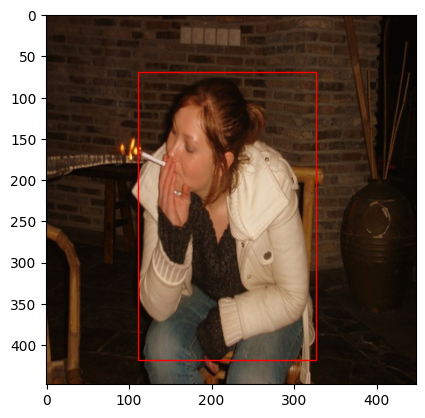

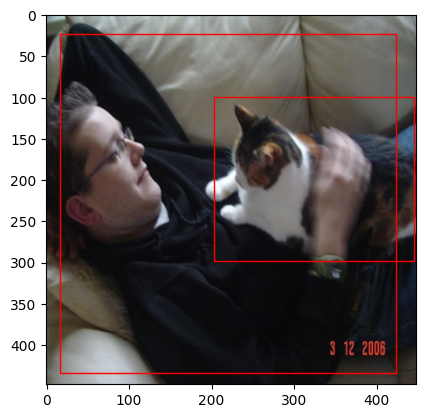

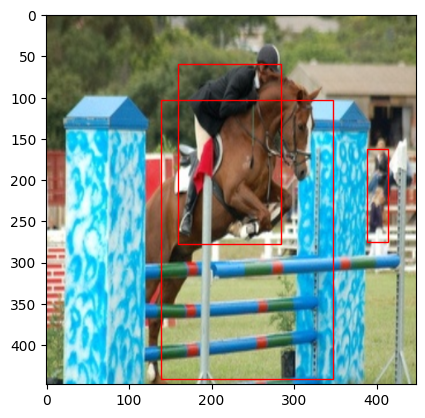

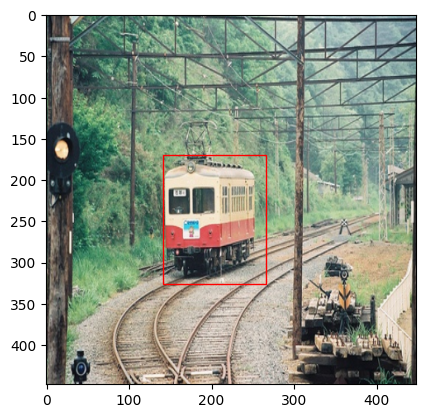

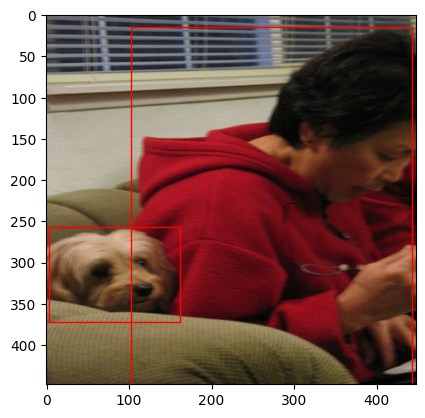

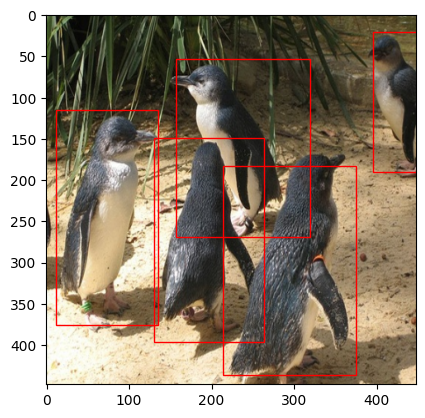

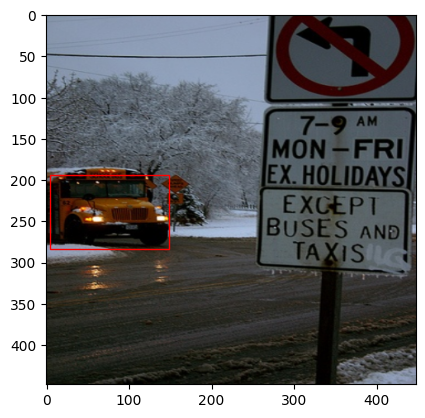

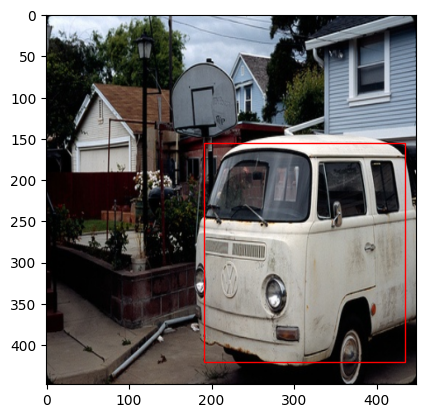

In [ ]:
# Kiểm tra xem đoạn mã đang chạy
if __name__ == "__main__":
  # Bắt đầu quá trình thực thi chương trình chính.
    main()

In [ ]:
import numpy as np

boxes_preds = np.array([[[1, 2], [3, 4]],
                        [[5, 6], [7, 8]],
                        [[9, 10], [11, 12]]])
box1_x1 = boxes_preds[..., 0:1]

print(box1_x1)

[[[ 1]
  [ 3]]

 [[ 5]
  [ 7]]

 [[ 9]
  [11]]]


In [ ]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":

      # Trích xuất tọa độ của các điểm đầu và cuối của box dự đoán và nhãn thực:
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    #Tính toán tọa độ của hình chữ nhật giao nhau:
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Tính diện tích của hình chữ nhật giao nhau (intersection):
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Tính diện tích của các box dự đoán và nhãn thực (box1_area và box2_area):
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Tính toán tỷ lệ độ chồng lấn (IoU):
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

# Tạo tensor giả định
boxes_preds = torch.tensor([[[1, 2, 3, 4], [5, 6, 7, 8]],
                            [[9, 10, 11, 12], [13, 14, 15, 16]],
                            [[17, 18, 19, 20], [21, 22, 23, 24]]], dtype=torch.float32)

boxes_labels = torch.tensor([[[0, 1, 2, 3], [4, 5, 6, 7]],
                             [[8, 9, 10, 11], [12, 13, 14, 15]],
                             [[16, 17, 18, 19], [20, 21, 22, 23]]], dtype=torch.float32)

# Gọi hàm và in kết quả
result = intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint")
print("Input (boxes_preds):")
print(boxes_preds)
print("\nInput (boxes_labels):")
print(boxes_labels)
print("\nOutput (IoU):")
print(result)


Input (boxes_preds):
tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.]],

        [[ 9., 10., 11., 12.],
         [13., 14., 15., 16.]],

        [[17., 18., 19., 20.],
         [21., 22., 23., 24.]]])

Input (boxes_labels):
tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.]],

        [[ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.]]])

Output (IoU):
tensor([[[0.2632],
         [0.5743]],

        [[0.7012],
         [0.7699]],

        [[0.8129],
         [0.8424]]])


In [ ]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

def demo_iou_function():
    # Tạo tensor giả định
    boxes_preds = torch.tensor([[[1, 2, 3, 4], [5, 6, 7, 8]],
                                [[9, 10, 11, 12], [13, 14, 15, 16]],
                                [[17, 18, 19, 20], [21, 22, 23, 24]]], dtype=torch.float32)

    boxes_labels = torch.tensor([[[0, 1, 2, 3], [4, 5, 6, 7]],
                                 [[8, 9, 10, 11], [12, 13, 14, 15]],
                                 [[16, 17, 18, 19], [20, 21, 22, 23]]], dtype=torch.float32)

    # Gọi hàm và in kết quả
    result = intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint")

    print("Input (boxes_preds):")
    print(boxes_preds)
    print("\nInput (boxes_labels):")
    print(boxes_labels)
    print("\nOutput (IoU):")
    print(result)

# Gọi hàm demo
demo_iou_function()


Input (boxes_preds):
tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.]],

        [[ 9., 10., 11., 12.],
         [13., 14., 15., 16.]],

        [[17., 18., 19., 20.],
         [21., 22., 23., 24.]]])

Input (boxes_labels):
tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.]],

        [[ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.]]])

Output (IoU):
tensor([[[0.2632],
         [0.5743]],

        [[0.7012],
         [0.7699]],

        [[0.8129],
         [0.8424]]])
